In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as pdr
import datetime
import numpy as np
import scipy.stats as scs
import scipy.optimize as sco
import json

In [2]:
name = input('Stock abb ')

Stock abb ms


In [3]:
all_stocks = []

In [4]:
all_stocks.append(name)

In [5]:
stock = yf.Ticker(name)
bs = stock.quarterly_balance_sheet
cf = stock.quarterly_cashflow
i_s = stock.quarterly_financials

In [6]:
stock.info

{'zip': '10036',
 'sector': 'Financial Services',
 'fullTimeEmployees': 74000,
 'longBusinessSummary': 'Morgan Stanley, a financial holding company, provides various financial products and services to corporations, governments, financial institutions, and individuals in the Americas, Europe, the Middle East, Africa, and Asia. The company operates through Institutional Securities, Wealth Management, and Investment Management segments. The Institutional Securities segment offers capital raising and financial advisory services, including services related to the underwriting of debt, equity, and other securities, as well as advice on mergers and acquisitions, restructurings, real estate, and project finance. This segment also provides sales and trading services, such as sales, financing, prime brokerage, and market-making services in equity and fixed income products consisting of foreign exchange and commodities; corporate and commercial real estate loans, which provides secured lending fa

In [7]:
yesterday = datetime.datetime.now() - datetime.timedelta(days=1)
yesterday.strftime('%Y-%m-%d')

try:
    try:
        df = pdr.get_data_yahoo(name, end = yesterday)
    except OverflowError           :
        print('Invalid Time!!! Return Default')
        df = pdr.get_data_yahoo(name, end=yesterday)
except KeyError:
    print('Not valid Stock')

In [8]:
df['ma5'] = df.loc[:, 'Close'].rolling(5).mean()
df['ma30'] = df.loc[:, 'Close'].rolling(30).mean()

def md(name, first_money, df):
    

    # data = data[:100]
    df = df[:]
    df[['Close', 'ma5', 'ma30']].plot()
    
    
    plt.show()
    
    
    sr1 = df['ma5'] < df['ma30']
    sr2 = df['ma5'] >= df['ma30']

    death_cross = df[sr1 & sr2.shift(1)].index  
    golden_cross = df[-(sr1 | sr2.shift(1))].index  


    
    money = first_money
    hold = 0   
    sr1 = pd.Series(1, index=golden_cross)
    sr2 = pd.Series(0, index=death_cross)
    sr = sr1.append(sr2)

    sr = sr.sort_index()

    for i in range(0, len(sr)):
        price = df['Open'][sr.index[i]]
        if sr.iloc[i] == 1:
            buy = money // (100 * price)

            hold += buy*100
            money -= buy*100*price
        else:
            money += hold * price
            hold = 0
    
    price = df['Open'][-1]
    now_money = hold * price + money
    print('earning: ', now_money - first_money)

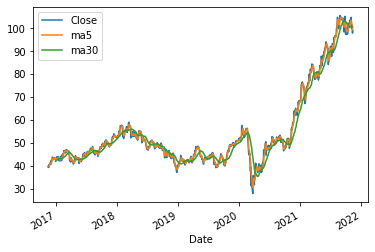

earning:  81235.0170135498


In [9]:
first_money = 100000
md(name, first_money, df)

In [10]:

def get_CCI(df,N):
    '''
         Commodity Channel Index
     
principle:
     Use the current stock price volatility to compare with the normal distribution range to draw the conclusion of overbought or oversold, which is used to capture trend reversal points.
algorithm:
　 The difference between the typical price and the N-day moving average of the typical price divided by the average absolute deviation of the typical price in N days.
usage:
     When CCI is less than -100, it is a buy signal, and when CCI is greater than 100, it is a sell signal;
     When the stock price diverges, it is an obvious warning signal.
parameter:
     N　 sets the number of days for calculating the moving average, generally 14.'''
    
    
    
    df['typ']=(df['High']+df['Low']+df['Close'])/3
    
    df['CCI']=((df['typ']-df['typ'].rolling(N).mean())/
               (0.015*abs(df['typ']-df['typ'].rolling(N).mean()).rolling(N).mean()))
    return df


In [11]:
get_CCI(df,14)

,High,Low,Open,Close,Volume,Adj Close,ma5,ma30,typ,CCI
Date,,,,,,,,,,
2016-11-14,39.880001,38.779999,38.880001,39.349998,25619000.0,34.794746,NaN,NaN,39.336666,NaN
2016-11-15,40.029999,38.410000,38.810001,40.000000,18608000.0,35.369503,NaN,NaN,39.480000,NaN
2016-11-16,39.480000,38.959999,39.009998,39.189999,18234900.0,34.653263,NaN,NaN,39.209999,NaN
2016-11-17,39.970001,38.720001,39.020000,39.970001,12676900.0,35.342968,NaN,NaN,39.553335,NaN
2016-11-18,40.669998,39.889999,40.000000,40.430000,16413300.0,35.749729,39.788000,NaN,40.329999,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-11-05,101.980003,99.730003,101.330002,99.870003,8447600.0,99.870003,102.186002,100.783001,100.526670,-61.930873
2021-11-08,101.800003,99.970001,100.459999,100.070000,7332000.0,100.070000,101.400002,100.615334,100.613335,-57.506406
2021-11-09,100.309998,98.279999,99.459999,99.709999,8756900.0,99.709999,100.410001,100.537668,99.433332,-97.621923


<AxesSubplot:xlabel='Date'>

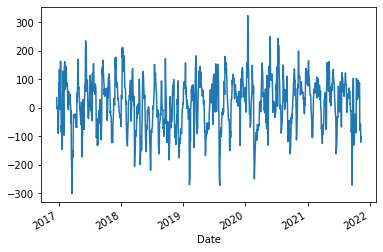

In [12]:
df.loc[:, 'CCI'].plot()

In [13]:
#  Relative strength index
"""It analyzes the intention and strength of market orders by calculating the percentage of volatility caused by price increases to 
the total volatility through the average number of closing increases and decreases over a period of time."""



"""
RSI must be a number between 0 and 100. The larger the RSI value, the larger the proportion of the fluctuation caused 
by the price increase in the whole period of time. When the RSI exceeds 70, we believe that the increase is too strong, 
and then it is likely to reverse and fall, so the area above 70 is defined as an overbought area and should be sold. Conversely, 
we define the area below 30 as an oversold area and should be bought. Note that the threshold settings of 30 and 70 here are not absolute. According to different targets, 
different market conditions, and the risk appetite of different investors, it can be adjusted appropriately.
"""
def RSI(Close, period):

    
    Chg = Close - Close.shift(1)
    Chg_pos = pd.Series(index=Chg.index, data=Chg[Chg>0])
    Chg_pos = Chg_pos.fillna(0)
    Chg_neg = pd.Series(index=Chg.index, data=-Chg[Chg<0])
    Chg_neg = Chg_neg.fillna(0)
    

    import numpy as np
    up_mean = []
    down_mean = []
    for i in range(period+1, len(Chg_pos)+1):
        up_mean.append(np.mean(Chg_pos.values[i-period:i]))
        down_mean.append(np.mean(Chg_neg.values[i-period:i]))
    

    rsi = []
    for i in range(len(up_mean)):
        rsi.append( 100 * up_mean[i] / ( up_mean[i] + down_mean[i] ) )
    rsi_series = pd.Series(index = Close.index[period:], data = rsi)
    return rsi_series

In [14]:
rsi = RSI(df.loc[:, 'Close'], 14)

In [15]:
df['RSI'] = rsi

<AxesSubplot:xlabel='Date'>

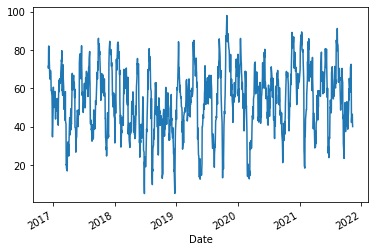

In [16]:
df.loc[:, 'RSI'].plot()

In [17]:
df

,High,Low,Open,Close,Volume,Adj Close,ma5,ma30,typ,CCI,RSI
Date,,,,,,,,,,,
2016-11-14,39.880001,38.779999,38.880001,39.349998,25619000.0,34.794746,NaN,NaN,39.336666,NaN,NaN
2016-11-15,40.029999,38.410000,38.810001,40.000000,18608000.0,35.369503,NaN,NaN,39.480000,NaN,NaN
2016-11-16,39.480000,38.959999,39.009998,39.189999,18234900.0,34.653263,NaN,NaN,39.209999,NaN,NaN
2016-11-17,39.970001,38.720001,39.020000,39.970001,12676900.0,35.342968,NaN,NaN,39.553335,NaN,NaN
2016-11-18,40.669998,39.889999,40.000000,40.430000,16413300.0,35.749729,39.788000,NaN,40.329999,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-05,101.980003,99.730003,101.330002,99.870003,8447600.0,99.870003,102.186002,100.783001,100.526670,-61.930873,44.630403
2021-11-08,101.800003,99.970001,100.459999,100.070000,7332000.0,100.070000,101.400002,100.615334,100.613335,-57.506406,44.084508
2021-11-09,100.309998,98.279999,99.459999,99.709999,8756900.0,99.709999,100.410001,100.537668,99.433332,-97.621923,46.473630


In [18]:
result = df.to_json(orient="split")

In [38]:
df.iloc[:, 0]

Date
2016-11-14     39.880001
2016-11-15     40.029999
2016-11-16     39.480000
2016-11-17     39.970001
2016-11-18     40.669998
                 ...    
2021-11-05    101.980003
2021-11-08    101.800003
2021-11-09    100.309998
2021-11-10     99.620003
2021-11-11     99.309998
Name: High, Length: 1258, dtype: float64

# common size B|S I|S and C|F

In [19]:
def common_size(bs, cf, i_s):
    csbs = bs.copy()
    csis = i_s.copy()
    cscf = cf.copy()

    for i, count in enumerate(csbs.loc['Total Assets', :]):
        csbs.iloc[:, i] = csbs.iloc[:, i]/ count
    for i, count in enumerate(csis.loc['Total Revenue', :]):
        csis.iloc[:, i] = csis.copy().iloc[:, i]/ count
        cscf.iloc[:, i] = cscf.iloc[:, i]/ count
    
    return csbs, csis, cscf

In [20]:
common_size_bs, common_size_is, common_size_cf  = common_size(bs, cf, i_s)

In [21]:
common_size_cf

,2021-09-30,2021-06-30,2021-03-31,2020-12-31
Investments,-0.578933,1.000745,-0.818754,0.086290
Change To Liabilities,0.671863,0.450369,0.208029,1.173387
Total Cashflows From Investing Activities,-1.026706,0.211193,-1.435269,-0.033724
Net Borrowings,0.547279,0.484653,0.034353,0.644355
Total Cash From Financing Activities,0.798685,0.032861,0.608436,2.555645
Change To Operating Activities,-1.159696,-0.108002,1.048858,-2.237610
Net Income,0.251271,0.237889,0.262103,0.248167
Change In Cash,-0.177388,0.566570,0.792926,0.797801
Repurchase Of Stock,-0.245916,-0.204485,-0.164260,-0.003666
Effect Of Exchange Rate,-0.093608,0.009825,-0.090209,0.137317


In [22]:
bs

,2021-09-30,2021-06-30,2021-03-31,2020-12-31
Intangible Assets,8.514000e+09,8.690000e+09,8.846000e+09,4.980000e+09
Capital Surplus,2.850400e+10,2.803000e+10,2.740600e+10,2.554600e+10
Total Liab,1.083357e+12,1.053643e+12,1.051184e+12,1.012713e+12
Total Stockholder Equity,9.815300e+10,9.912000e+10,9.850900e+10,9.253100e+10
Minority Interest,1.216000e+09,1.292000e+09,1.329000e+09,1.368000e+09
Other Current Liab,1.347870e+11,1.377870e+11,1.565780e+11,1.311700e+11
Total Assets,1.190476e+12,1.161805e+12,1.158772e+12,1.115862e+12
Common Stock,2.000000e+07,2.000000e+07,2.000000e+07,2.000000e+07
Other Current Assets,1.226620e+11,1.200010e+11,1.268300e+11,1.453910e+11
Retained Earnings,8.709900e+10,8.479100e+10,8.203400e+10,7.869400e+10


In [23]:
i_s

,2021-09-30,2021-06-30,2021-03-31,2020-12-31
Research Development,None,None,None,None
Effect Of Accounting Charges,None,None,None,None
Income Before Tax,4874000000.0,4566000000.0,5344000000.0,4430000000.0
Minority Interest,1216000000.0,1292000000.0,1329000000.0,1368000000.0
Net Income,3707000000.0,3511000000.0,4120000000.0,3385000000.0
Selling General Administrative,7227000000.0,7704000000.0,7940000000.0,6595000000.0
Gross Profit,13140000000.0,13199000000.0,14076000000.0,12167000000.0
Ebit,0.0,0.0,0.0,0.0
Operating Income,5889000000.0,5422000000.0,6234000000.0,5572000000.0
Other Operating Expenses,None,None,None,None


In [24]:
cf

,2021-09-30,2021-06-30,2021-03-31,2020-12-31
Investments,-8.541000e+09,1.477000e+10,-1.287000e+10,1.177000e+09
Change To Liabilities,9.912000e+09,6.647000e+09,3.270000e+09,1.600500e+10
Total Cashflows From Investing Activities,-1.514700e+10,3.117000e+09,-2.256100e+10,-4.600000e+08
Net Borrowings,8.074000e+09,7.153000e+09,5.400000e+08,8.789000e+09
Total Cash From Financing Activities,1.178300e+10,4.850000e+08,9.564000e+09,3.485900e+10
Change To Operating Activities,-1.710900e+10,-1.594000e+09,1.648700e+10,-3.052100e+10
Net Income,3.707000e+09,3.511000e+09,4.120000e+09,3.385000e+09
Change In Cash,-2.617000e+09,8.362000e+09,1.246400e+10,1.088200e+10
Repurchase Of Stock,-3.628000e+09,-3.018000e+09,-2.582000e+09,-5.000000e+07
Effect Of Exchange Rate,-1.381000e+09,1.450000e+08,-1.418000e+09,1.873000e+09


## stock combination

In [25]:
stock_name_list = ["MS","MSFT","AMZN","TSLA","GS"]

In [26]:
all_stocks = stock_name_list

In [27]:
all_dfs = yf.download(all_stocks, end = yesterday).loc[:, 'Close']

[*********************100%***********************]  5 of 5 completed


<AxesSubplot:xlabel='Date'>

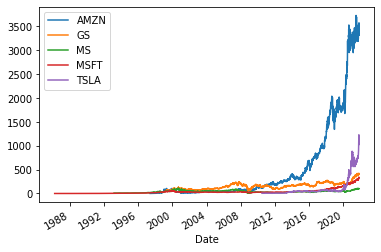

In [28]:
all_dfs.plot()

In [29]:
all_dfs

,AMZN,GS,MS,MSFT,TSLA
Date,,,,,
1986-03-13,NaN,NaN,NaN,0.097222,NaN
1986-03-14,NaN,NaN,NaN,0.100694,NaN
1986-03-17,NaN,NaN,NaN,0.102431,NaN
1986-03-18,NaN,NaN,NaN,0.099826,NaN
1986-03-19,NaN,NaN,NaN,0.098090,NaN
...,...,...,...,...,...
2021-11-05,3518.989990,407.079987,99.870003,336.059998,1222.089966
2021-11-08,3488.979980,408.339996,100.070000,336.989990,1162.939941
2021-11-09,3576.229980,405.350006,99.709999,335.950012,1023.500000


In [30]:
log_returns = np.log(all_dfs.pct_change()+1)

In [31]:
log_returns.mean()*252

AMZN    0.305774
GS      0.077487
MS      0.088699
MSFT    0.228069
TSLA    0.475607
dtype: float64

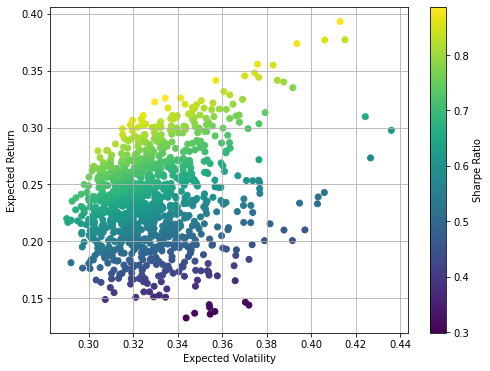

In [32]:
port_returns = []
port_variance = []
for p in range(1000):
    weights = np.random.random(len(all_stocks))
    weights /=np.sum(weights)
    port_returns.append(np.sum(log_returns.mean()*252*weights))
    port_variance.append(np.sqrt(np.dot(weights.T, np.dot(log_returns.cov()*252, weights))))

port_returns = np.array(port_returns)
port_variance = np.array(port_variance)


risk_free = 0.03
plt.figure(figsize=(8, 6))
plt.scatter(port_variance, port_returns, c=(port_returns-risk_free)/port_variance, marker = 'o')
plt.grid(True)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label = 'Sharpe Ratio')

In [33]:
def stats(weights):
    weights = np.array(weights)
    port_returns = np.sum(log_returns.mean()*weights)*252
    port_variance = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov()*252,weights)))
    return np.array([port_returns, port_variance, port_returns/port_variance])


def min_sharpe(weights):
    return -stats(weights)[2]


x0 = 5*[1./5]

bnds = tuple((0,1) for x in range(len(all_stocks)))


cons = ({'type':'eq', 'fun':lambda x: np.sum(x)-1})

opts = sco.minimize(min_sharpe,
                    x0, 
                    method = 'SLSQP', 
                    bounds = bnds, 
                    constraints = cons)
opts

     fun: -1.0070906419185783
     jac: array([-1.27345324e-04,  2.06576422e-01,  2.75978938e-01,  6.68913126e-05,
       -1.54525042e-05])
 message: 'Optimization terminated successfully'
    nfev: 43
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([1.60425064e-01, 0.00000000e+00, 5.41558985e-17, 4.05765539e-01,
       4.33809397e-01])

In [34]:
#Portfolio optimization 2-minimum variance

def min_variance(weights):
    return stats(weights)[1]

optv = sco.minimize(min_variance, 
                    x0, 
                    method = 'SLSQP', 
                    bounds = bnds, 
                    constraints = cons)
optv

     fun: 0.2865327522144285
     jac: array([0.28681398, 0.28657898, 0.32141417, 0.28648043, 0.286461  ])
 message: 'Optimization terminated successfully'
    nfev: 48
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([6.31649784e-02, 3.43935666e-01, 4.55364912e-18, 4.57201274e-01,
       1.35698082e-01])

In [35]:
def min_variance(weights):
    return stats(weights)[1]

target_returns = np.linspace(0.0,0.5,50)
target_variance = []
for tar in target_returns:
    cons = ({'type':'eq','fun':lambda x:stats(x)[0]-tar},{'type':'eq','fun':lambda x:np.sum(x)-1})
    res = sco.minimize(min_variance, x0, method = 'SLSQP', bounds = bnds, constraints = cons)
    target_variance.append(res['fun'])

target_variance = np.array(target_variance)

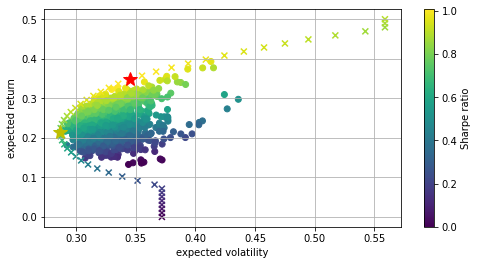

In [36]:
plt.figure(figsize = (8,4))

plt.scatter(port_variance, port_returns, c = port_returns/port_variance,marker = 'o')

plt.scatter(target_variance,target_returns, c = target_returns/target_variance, marker = 'x')

plt.plot(stats(opts['x'])[1], stats(opts['x'])[0], 'r*', markersize = 15.0)

plt.plot(stats(optv['x'])[1], stats(optv['x'])[0], 'y*', markersize = 15.0)

plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')

c